In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import math
from torch.utils.data import TensorDataset, DataLoader

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [27]:
data = pd.read_csv('/home/aibig25/hong_sj/trb/num.csv')
data = data.fillna(0)

unique_ids = data['sequence_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=41, random_state=42)
train_data = data[data['sequence_ID'].isin(train_ids)]
test_data = data[data['sequence_ID'].isin(test_ids)]

independent_vars = data.columns.difference(['center_x', 'center_y','center_x_ma','center_y_ma', 'ID', 'LC'])
dependent_vars = ['center_y_ma']

scaler = MinMaxScaler()

train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
test_data[independent_vars] = scaler.transform(test_data[independent_vars])

X_train = train_data[independent_vars]
y_train = train_data[dependent_vars]

X_test = test_data[independent_vars]
y_test = test_data[dependent_vars]

/tmp/ipykernel_71556/3224682186.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
/tmp/ipykernel_71556/3224682186.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[independent_vars] = scaler.transform(test_data[independent_vars])


In [28]:
# 입력 및 예측 시퀀스 길이 정의
input_sequence_length = 60
output_sequence_length = 30

def create_sequences(data, input_sequence_length, output_sequence_length):
    X = []
    y = []

    for i in range(len(data) - input_sequence_length - output_sequence_length + 1):
        X.append(data.iloc[i:(i + input_sequence_length)][independent_vars].values)
        y.append(data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values)
    
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, input_sequence_length, output_sequence_length)
X_test, y_test = create_sequences(test_data, input_sequence_length, output_sequence_length)

In [29]:
# 데이터셋을 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [30]:
class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, output_dim, lstm_hidden_dim, lstm_layers=1):
        super(TrajectoryTransformer, self).__init__()
        self.model_dim = model_dim
        
        # Linear layer to transform input dimensions to model dimensions
        self.encoder = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        self.tgt_linear = nn.Linear(1, model_dim)  # Linear layer for transforming tgt dimensions
        
        # Define transformer encoder and decoder
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(model_dim, num_heads, lstm_hidden_dim, lstm_layers)
            for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(model_dim, num_heads, lstm_hidden_dim, lstm_layers)
            for _ in range(num_decoder_layers)
        ])
        
        self.decoder = nn.Linear(model_dim, output_dim)

    def forward(self, src, tgt):
        # Encoding source input
        src = self.encoder(src)
        src = src * math.sqrt(self.model_dim)
        src = self.pos_encoder(src.permute(1, 0, 2))  # Add positional encoding

        # Processing target input
        tgt = tgt.squeeze(-1)
        original_shape = tgt.shape
        tgt = tgt.reshape(-1, 1)
        tgt = self.tgt_linear(tgt)
        tgt = tgt.view(original_shape[0], original_shape[1], -1)
        tgt = tgt * math.sqrt(self.model_dim)
        tgt = self.pos_encoder(tgt.permute(1, 0, 2))  # Add positional encoding

        # Apply encoder and decoder layers
        for layer in self.encoder_layers:
            src = layer(src)
        
        for layer in self.decoder_layers:
            tgt = layer(tgt, src)

        # Decode output and return
        output = self.decoder(tgt.permute(1, 0, 2))
        return output

class TransformerEncoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads, lstm_hidden_dim, lstm_layers):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(model_dim, num_heads, dropout=0.1)
        
        # LSTM instead of Feedforward layer
        self.lstm = nn.LSTM(input_size=model_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(lstm_hidden_dim, model_dim)
        
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, src):
        # Self-attention
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout(src2)
        src = self.norm1(src)
        
        # LSTM
        lstm_out, _ = self.lstm(src.permute(1, 0, 2))  # LSTM requires (batch_size, seq_length, input_size)
        lstm_out = lstm_out.permute(1, 0, 2)  # Transpose back to (seq_length, batch_size, input_size)
        
        # Linear transformation
        src2 = self.linear(lstm_out)
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads, lstm_hidden_dim, lstm_layers):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(model_dim, num_heads, dropout=0.1)
        self.multihead_attn = nn.MultiheadAttention(model_dim, num_heads, dropout=0.1)
        
        # LSTM instead of Feedforward layer
        self.lstm = nn.LSTM(input_size=model_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(lstm_hidden_dim, model_dim)
        
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, tgt, memory):
        # Self-attention for the target sequence
        tgt2 = self.self_attn(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm1(tgt)
        
        # Cross-attention with encoder memory
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm2(tgt)
        
        # LSTM
        lstm_out, _ = self.lstm(tgt.permute(1, 0, 2))  # LSTM requires (batch_size, seq_length, input_size)
        lstm_out = lstm_out.permute(1, 0, 2)  # Transpose back to (seq_length, batch_size, input_size)
        
        # Linear transformation
        tgt2 = self.linear(lstm_out)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm3(tgt)
        return tgt

# 위치 인코딩 추가
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


In [31]:
# 모델 초기화
input_dim = len(independent_vars)
output_dim = len(dependent_vars)
model_dim = 160
num_heads = 5
num_encoder_layers = 3
num_decoder_layers = 3
lstm_hidden_dim = 50
lstm_layers = 1

model = TrajectoryTransformer(input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, output_dim, lstm_hidden_dim, lstm_layers)

# 옵티마이저와 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

/home/aibig25/anaconda3/envs/solar/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


X_vehicle shape: (172, 60, 26)
y_vehicle shape: (172, 30, 1)


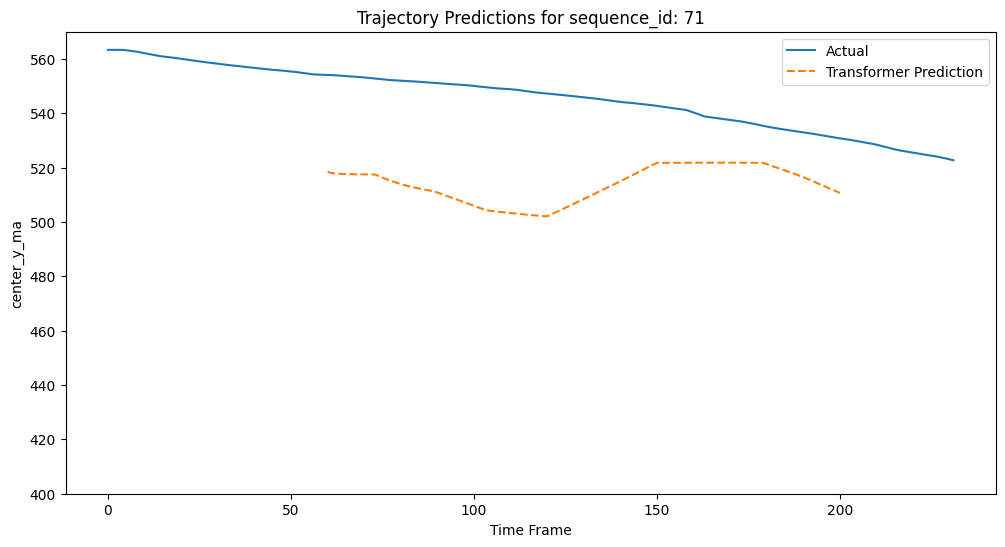

In [46]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 차량 ID 및 파라미터 설정
sequence_id = 71

# sequence_ID에 해당하는 데이터 필터링 및 스케일링
vehicle_data = data[data['sequence_ID'] == sequence_id].copy()
vehicle_data[independent_vars] = scaler.transform(vehicle_data[independent_vars])
total_frames = len(vehicle_data)

# input_sequence_length와 output_sequence_length를 적용하여 데이터 전처리
def create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length):
    X = []
    y = []
    
    # 시퀀스를 끝까지 포함하도록 범위 조정
    for i in range(len(vehicle_data) - input_sequence_length + 1):
        X_seq = vehicle_data.iloc[i:(i + input_sequence_length)][independent_vars].values
        if i + input_sequence_length + output_sequence_length <= len(vehicle_data):
            y_seq = vehicle_data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values
        else:
            remaining_length = len(vehicle_data) - (i + input_sequence_length)
            if remaining_length > 0:
                y_seq = vehicle_data.iloc[(i + input_sequence_length):][dependent_vars].values
                y_seq = np.pad(y_seq, ((0, output_sequence_length - remaining_length), (0, 0)), mode='constant')
            else:
                continue  # 마지막 시퀀스에 대해 충분한 길이가 없으면 생략
        
        X.append(X_seq)
        y.append(y_seq)
    
    # 최종 시퀀스의 개수 조정
    if len(X) > len(y):
        X.pop()

    return np.array(X), np.array(y)

X_vehicle, y_vehicle = create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length)

# 크기 출력으로 문제를 확인합니다.
print(f"X_vehicle shape: {X_vehicle.shape}")
print(f"y_vehicle shape: {y_vehicle.shape}")

# 데이터셋을 텐서로 변환
assert X_vehicle.shape[0] == y_vehicle.shape[0], "Size mismatch between X and y"
vehicle_dataset = TensorDataset(torch.tensor(X_vehicle, dtype=torch.float32), torch.tensor(y_vehicle, dtype=torch.float32))
vehicle_loader = DataLoader(vehicle_dataset, batch_size=1, shuffle=False)

# 모델 초기화 및 가중치 로드
model.load_state_dict(torch.load('/home/aibig25/hong_sj/trb/transformer/new/code/2_1.pth'))

# 모델을 평가 모드로 설정
model.eval()

# 예측 수행
trans_predictions = []

with torch.no_grad():
    for X_batch, _ in vehicle_loader:
        batch_size = X_batch.size(0)
        tgt = torch.zeros((batch_size, output_sequence_length, 1), dtype=torch.float32).to(X_batch.device)
        trans_outputs = model(X_batch, tgt)
        trans_predictions.extend(trans_outputs.cpu().numpy())

trans_predictions = np.array(trans_predictions)

# 중복된 시점의 예측 값을 평균화
def average_predictions(predictions, input_sequence_length, output_sequence_length):
    num_predictions = len(predictions) + output_sequence_length - 1
    avg_predictions = np.zeros(num_predictions)
    counts = np.zeros(num_predictions)

    for i, pred in enumerate(predictions):
        for j in range(output_sequence_length):
            idx = i + input_sequence_length + j
            if idx < num_predictions:
                avg_predictions[idx] += pred[j]
                counts[idx] += 1

    avg_predictions = avg_predictions[input_sequence_length:]
    counts = counts[input_sequence_length:]
    
    avg_predictions /= counts
    return avg_predictions

avg_trans_predictions = average_predictions(trans_predictions, input_sequence_length, output_sequence_length)

# 시각화 범위를 조정하여 마지막 60프레임에 대한 예측 포함
plt.figure(figsize=(12, 6))
plt.plot(range(len(vehicle_data)), vehicle_data['center_y_ma'], label='Actual')
plt.plot(range(input_sequence_length, input_sequence_length + len(avg_trans_predictions)), 
         avg_trans_predictions, label='Transformer Prediction', linestyle='--')
plt.xlabel('Time Frame')
plt.ylabel('center_y_ma')
plt.ylim(400, 570)
plt.title(f'Trajectory Predictions for sequence_id: {sequence_id}')
plt.legend()
plt.show()
